# Feature Engineering & Extraction

In [1]:
# Necessary imports
import numpy as np
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
train_data = pd.read_json('train_data.json',orient="index")
test_data = pd.read_json('test_data.json',orient='index')

In [3]:
#set index
train_data.reset_index(level = 0, inplace = True)
train_data.rename(columns={'index':'ID'}, inplace=True)

test_data.reset_index(level = 0, inplace = True)
test_data.rename(columns={'index':'ID'}, inplace=True)

In [4]:
#check data
print ('Train data has {} rows and {} columns'.format(train_data.shape[0],train_data.shape[1]))
print ('test_data data has {} rows and {} columns'.format(test_data.shape[0],test_data.shape[1]))

Train data has 200000 rows and 7 columns
test_data data has 100000 rows and 6 columns


In [5]:
#Encode Target Variable
train_data = train_data.replace({'segment':{'pos':1,'neg':0}})

In [6]:
#check target variable count
train_data['segment'].value_counts()/train_data.shape[0]

0    0.923725
1    0.076275
Name: segment, dtype: float64

In [7]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 7 columns):
ID         200000 non-null object
cities     200000 non-null object
dow        200000 non-null object
genres     200000 non-null object
segment    200000 non-null int64
titles     200000 non-null object
tod        200000 non-null object
dtypes: int64(1), object(6)
memory usage: 10.7+ MB


## Necessary Functions for forming lists

In [8]:
# For forming lists of watch time from titles,genres,cities,tod,dow

def form_list(df,col):
    #the rows aren't list exactly. They are object, so we convert them to list and extract the watch time
    #w1 = train_data['titles']
    w1 = df[col]
    w1 = w1.str.split(',')

    #create a nested list of numbers
    main = []
    for i in np.arange(df.shape[0]):
        d1 = w1[i]
        nest = []
        nest = [re.sub(pattern = '.*\:', repl=' ', string= d1[k]) for k in list(np.arange(len(d1)))]
        main.append(nest)
    return main

In [9]:
## Turns out, there are blank values in the list, we need to fix them before we could add¶
## Fixing blanks in the list now

def fill_blank(main):
    blanks = []
    for i in np.arange(len(main)):
        if '' in main[i]:
            #print ("{} blanks found".format(len(blanks)))
            blanks.append(i)

    #replacing blanks with 0
    for i in blanks:
        main[i] = [x.replace('','0') for x in main[i]]

    #converting string to integers
    main = [[int(y) for y in x] for x in main]
    return main

In [10]:
# Perform aggregate functions like sum,mean,median,max,min
def aggregate(df,col):
    main = df[col]
    #adding the watch time
    tosum = []
    for i in np.arange(len(main)):
        s = sum(main[i])
        tosum.append(s)
    col1 = col + '_sum'
    df[col1] = tosum

    #Finding the mean the watch time
    tomean = []
    for i in np.arange(len(main)):
        me = np.mean(main[i])
        tomean.append(me)
    col2 = col + '_mean'
    df[col2] = tomean


    #Finding the median the watch time
    tomedian = []
    for i in np.arange(len(main)):
        med = np.median(main[i])
        tomedian.append(med)
    col3 = col + '_median'
    df[col3] = tomedian

    #Finding the max the watch time
    tomax = []
    for i in np.arange(len(main)):
        maxi = main[i][len(main[i]) - 1]
        tomax.append(maxi)
    col4 = col + '_max'
    df[col4] = tomax

    #Finding the min the watch time
    tomin = []
    for i in np.arange(len(main)):
        mini = main[i][0]
        tomin.append(mini)
    col5 = col + '_min'
    df[col5] = tomin

In [11]:
#count variables
def wcount(p):
    return p.count(',')+1

In [12]:
# To create columns of genres and cities
def string_genres_time(genre, string):
    if genre in string:
            prbmStr = string[string.index(genre) :]
            problemStr = prbmStr[prbmStr.index(':')+1:]
            if ',' in problemStr:
                return int(problemStr[0:problemStr.index(',')])
            else:
                return int(problemStr[0:])
    else:
        return 0

In [13]:
# To create columns of dow
def string_dow_time(genre, string):
    if genre in string:
        prbmStr = string[string.index(genre) :]
        problemStr = prbmStr[prbmStr.index(':')+1:]
        if ',' in problemStr:
            return int(problemStr[0:problemStr.index(',')])
        else:
            return int(problemStr[0:])
    else:
        return 0

In [14]:
# To create columns of tod
def string_tod_time(genre, string):
    if genre in string:
        prbmStr = string[string.index(genre) :]
        #print(prbmStr)
        problemStr = prbmStr[prbmStr.index(':')+1:]
        #print(problemStr)
        #print(problemStr.index(','))
        if ',' in problemStr:
            return int(problemStr[0:problemStr.index(',')])
        else:
            return int(problemStr[0:])
    else:
        todData = genre[1:]
        if todData in string:
            if string.index(todData) == 0:
                prbmStr = string[string.index(todData) :]
                #print(prbmStr)
                problemStr = prbmStr[prbmStr.index(':')+1:]
                #print(problemStr)
                #print(problemStr.index(','))
                if ',' in problemStr:
                    return int(problemStr[0:problemStr.index(',')])
                else:
                    return int(problemStr[0:])
            else:
                return 0
        else:
            return 0

In [15]:
# Counting the number of capital letters
pLu = "[A-Z\u00C0-\u00D6\u00D8-\u00DE\u0100\u0102\u0104\u0106\u0108\u010A\u010C\u010E\u0110\u0112\u0114\u0116\u0118\u011A\u011C\u011E\u0120\u0122\u0124\u0126\u0128\u012A\u012C\u012E\u0130\u0132\u0134\u0136\u0139\u013B\u013D\u013F\u0141\u0143\u0145\u0147\u014A\u014C\u014E\u0150\u0152\u0154\u0156\u0158\u015A\u015C\u015E\u0160\u0162\u0164\u0166\u0168\u016A\u016C\u016E\u0170\u0172\u0174\u0176\u0178\u0179\u017B\u017D\u0181\u0182\u0184\u0186\u0187\u0189-\u018B\u018E-\u0191\u0193\u0194\u0196-\u0198\u019C\u019D\u019F\u01A0\u01A2\u01A4\u01A6\u01A7\u01A9\u01AC\u01AE\u01AF\u01B1-\u01B3\u01B5\u01B7\u01B8\u01BC\u01C4\u01C7\u01CA\u01CD\u01CF\u01D1\u01D3\u01D5\u01D7\u01D9\u01DB\u01DE\u01E0\u01E2\u01E4\u01E6\u01E8\u01EA\u01EC\u01EE\u01F1\u01F4\u01F6-\u01F8\u01FA\u01FC\u01FE\u0200\u0202\u0204\u0206\u0208\u020A\u020C\u020E\u0210\u0212\u0214\u0216\u0218\u021A\u021C\u021E\u0220\u0222\u0224\u0226\u0228\u022A\u022C\u022E\u0230\u0232\u023A\u023B\u023D\u023E\u0241\u0243-\u0246\u0248\u024A\u024C\u024E\u0370\u0372\u0376\u037F\u0386\u0388-\u038A\u038C\u038E\u038F\u0391-\u03A1\u03A3-\u03AB\u03CF\u03D2-\u03D4\u03D8\u03DA\u03DC\u03DE\u03E0\u03E2\u03E4\u03E6\u03E8\u03EA\u03EC\u03EE\u03F4\u03F7\u03F9\u03FA\u03FD-\u042F\u0460\u0462\u0464\u0466\u0468\u046A\u046C\u046E\u0470\u0472\u0474\u0476\u0478\u047A\u047C\u047E\u0480\u048A\u048C\u048E\u0490\u0492\u0494\u0496\u0498\u049A\u049C\u049E\u04A0\u04A2\u04A4\u04A6\u04A8\u04AA\u04AC\u04AE\u04B0\u04B2\u04B4\u04B6\u04B8\u04BA\u04BC\u04BE\u04C0\u04C1\u04C3\u04C5\u04C7\u04C9\u04CB\u04CD\u04D0\u04D2\u04D4\u04D6\u04D8\u04DA\u04DC\u04DE\u04E0\u04E2\u04E4\u04E6\u04E8\u04EA\u04EC\u04EE\u04F0\u04F2\u04F4\u04F6\u04F8\u04FA\u04FC\u04FE\u0500\u0502\u0504\u0506\u0508\u050A\u050C\u050E\u0510\u0512\u0514\u0516\u0518\u051A\u051C\u051E\u0520\u0522\u0524\u0526\u0528\u052A\u052C\u052E\u0531-\u0556\u10A0-\u10C5\u10C7\u10CD\u13A0-\u13F5\u1E00\u1E02\u1E04\u1E06\u1E08\u1E0A\u1E0C\u1E0E\u1E10\u1E12\u1E14\u1E16\u1E18\u1E1A\u1E1C\u1E1E\u1E20\u1E22\u1E24\u1E26\u1E28\u1E2A\u1E2C\u1E2E\u1E30\u1E32\u1E34\u1E36\u1E38\u1E3A\u1E3C\u1E3E\u1E40\u1E42\u1E44\u1E46\u1E48\u1E4A\u1E4C\u1E4E\u1E50\u1E52\u1E54\u1E56\u1E58\u1E5A\u1E5C\u1E5E\u1E60\u1E62\u1E64\u1E66\u1E68\u1E6A\u1E6C\u1E6E\u1E70\u1E72\u1E74\u1E76\u1E78\u1E7A\u1E7C\u1E7E\u1E80\u1E82\u1E84\u1E86\u1E88\u1E8A\u1E8C\u1E8E\u1E90\u1E92\u1E94\u1E9E\u1EA0\u1EA2\u1EA4\u1EA6\u1EA8\u1EAA\u1EAC\u1EAE\u1EB0\u1EB2\u1EB4\u1EB6\u1EB8\u1EBA\u1EBC\u1EBE\u1EC0\u1EC2\u1EC4\u1EC6\u1EC8\u1ECA\u1ECC\u1ECE\u1ED0\u1ED2\u1ED4\u1ED6\u1ED8\u1EDA\u1EDC\u1EDE\u1EE0\u1EE2\u1EE4\u1EE6\u1EE8\u1EEA\u1EEC\u1EEE\u1EF0\u1EF2\u1EF4\u1EF6\u1EF8\u1EFA\u1EFC\u1EFE\u1F08-\u1F0F\u1F18-\u1F1D\u1F28-\u1F2F\u1F38-\u1F3F\u1F48-\u1F4D\u1F59\u1F5B\u1F5D\u1F5F\u1F68-\u1F6F\u1FB8-\u1FBB\u1FC8-\u1FCB\u1FD8-\u1FDB\u1FE8-\u1FEC\u1FF8-\u1FFB\u2102\u2107\u210B-\u210D\u2110-\u2112\u2115\u2119-\u211D\u2124\u2126\u2128\u212A-\u212D\u2130-\u2133\u213E\u213F\u2145\u2183\u2C00-\u2C2E\u2C60\u2C62-\u2C64\u2C67\u2C69\u2C6B\u2C6D-\u2C70\u2C72\u2C75\u2C7E-\u2C80\u2C82\u2C84\u2C86\u2C88\u2C8A\u2C8C\u2C8E\u2C90\u2C92\u2C94\u2C96\u2C98\u2C9A\u2C9C\u2C9E\u2CA0\u2CA2\u2CA4\u2CA6\u2CA8\u2CAA\u2CAC\u2CAE\u2CB0\u2CB2\u2CB4\u2CB6\u2CB8\u2CBA\u2CBC\u2CBE\u2CC0\u2CC2\u2CC4\u2CC6\u2CC8\u2CCA\u2CCC\u2CCE\u2CD0\u2CD2\u2CD4\u2CD6\u2CD8\u2CDA\u2CDC\u2CDE\u2CE0\u2CE2\u2CEB\u2CED\u2CF2\uA640\uA642\uA644\uA646\uA648\uA64A\uA64C\uA64E\uA650\uA652\uA654\uA656\uA658\uA65A\uA65C\uA65E\uA660\uA662\uA664\uA666\uA668\uA66A\uA66C\uA680\uA682\uA684\uA686\uA688\uA68A\uA68C\uA68E\uA690\uA692\uA694\uA696\uA698\uA69A\uA722\uA724\uA726\uA728\uA72A\uA72C\uA72E\uA732\uA734\uA736\uA738\uA73A\uA73C\uA73E\uA740\uA742\uA744\uA746\uA748\uA74A\uA74C\uA74E\uA750\uA752\uA754\uA756\uA758\uA75A\uA75C\uA75E\uA760\uA762\uA764\uA766\uA768\uA76A\uA76C\uA76E\uA779\uA77B\uA77D\uA77E\uA780\uA782\uA784\uA786\uA78B\uA78D\uA790\uA792\uA796\uA798\uA79A\uA79C\uA79E\uA7A0\uA7A2\uA7A4\uA7A6\uA7A8\uA7AA-\uA7AD\uA7B0-\uA7B4\uA7B6\uFF21-\uFF3A]"
p = re.compile(pLu)

In [16]:
# Letters in the titles
def len_title(row):
    lst = []
    for title in row:
        c=0
        for word in title.split():
            c += len(word)
        lst.append(c)
    return lst

## Creating separate dow dataframes for each feature since data is alot. Likewise we will create for other columns later on

In [17]:
dow_train_df = train_data.copy(deep=True)
dow_test_df = test_data.copy(deep=True)

## Deleting columns not required for dow

In [18]:
dow_train_df.drop(['cities','genres','titles','tod'], inplace=True, axis=1)
dow_test_df.drop(['cities','genres','titles','tod'], inplace=True, axis=1)

In [19]:
dow_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 3 columns):
ID         200000 non-null object
dow        200000 non-null object
segment    200000 non-null int64
dtypes: int64(1), object(2)
memory usage: 4.6+ MB


## dow- day of the week(range 1-7 indicate monday to sunday)

### Train Data

In [20]:
# Forming a list of dow for each id
dow_train_df['g2'] = [re.sub(pattern='\:\d+', repl='', string = x) for x in dow_train_df['dow']]
dow_train_df['g2'] = dow_train_df['g2'].apply(lambda x: x.split(','))

In [21]:
t2 = pd.Series(dow_train_df['g2']).apply(frozenset).to_frame(name='t_dow')

In [22]:
# Counting the number of dow for each record
# using frozenset trick - might take few minutes to process
for t_dow in frozenset.union(*t2.t_dow):
    t2[t_dow] = t2.apply(lambda _: int(t_dow in _.t_dow), axis = 1)
    
dow_train_df = pd.concat([dow_train_df.reset_index(drop=True), t2], axis=1)

In [23]:
# Aggregating dow on the basis of watch times of each dow
main = form_list(dow_train_df,'dow')
dow_train_df['dow_time'] = fill_blank(main)
aggregate(dow_train_df,'dow_time')
dow_train_df['dow_count'] = dow_train_df['dow'].map(wcount)

In [24]:
# Segrating on dow
for i in np.arange(1,8):
    str_i = str(i) + ':'
    dow_str = 'dow_time_'+ str(i)
    dow_train_df[dow_str] = dow_train_df["dow"].apply(lambda x : string_dow_time(str_i, x))

In [25]:
dow_train_df.head()

,ID,dow,segment,g2,t_dow,5,6,3,2,7,...,dow_time_max,dow_time_min,dow_count,dow_time_1,dow_time_2,dow_time_3,dow_time_4,dow_time_5,dow_time_6,dow_time_7
0,train-121672,"5:482,4:3008,7:64",0,"[5, 4, 7]","(7, 5, 4)",1,0,0,0,1,...,64,482,3,0,0,0,3008,482,0,64
1,train-121673,"1:3257,3:9162,2:12893,5:9237,4:8503,7:25094,6:...",0,"[1, 3, 2, 5, 4, 7, 6]","(5, 6, 3, 2, 7, 1, 4)",1,1,1,1,1,...,15493,3257,7,3257,12893,9162,8503,9237,15493,25094
2,train-121670,"1:40,3:2700,2:4659,5:7338,4:6641,7:2218,6:5800",0,"[1, 3, 2, 5, 4, 7, 6]","(5, 6, 3, 2, 7, 1, 4)",1,1,1,1,1,...,5800,40,7,40,4659,2700,6641,7338,5800,2218
3,train-121671,"1:77,2:3883,5:122",0,"[1, 2, 5]","(1, 5, 2)",1,0,0,1,0,...,122,77,3,77,3883,0,0,122,0,0
4,train-121676,"1:6150,3:2378",1,"[1, 3]","(3, 1)",0,0,1,0,0,...,2378,6150,2,6150,0,2378,0,0,0,0


In [26]:
dow_train_df.to_csv('dow_train_features.csv')

### Test Data

In [27]:
dow_test_df['g2'] = [re.sub(pattern='\:\d+', repl='', string = x) for x in dow_test_df['dow']]
dow_test_df['g2'] = dow_test_df['g2'].apply(lambda x: x.split(','))
dow_test_df['g2'].head()

0    [1, 3, 2, 5, 4, 7, 6]
1                   [1, 3]
2                      [4]
3                   [1, 5]
4          [1, 3, 2, 4, 7]
Name: g2, dtype: object

In [28]:
t2_te = pd.Series(dow_test_df['g2']).apply(frozenset).to_frame(name='t_dow')

In [29]:
# Counting the number of dow for each record
# Using frozenset trick - might take few minutes to process
for t_dow in frozenset.union(*t2_te.t_dow):
    t2_te[t_dow] = t2_te.apply(lambda _: int(t_dow in _.t_dow), axis = 1)
    
dow_test_df = pd.concat([dow_test_df.reset_index(drop=True), t2_te], axis=1)

In [30]:
# Aggregating dow on the basis of watch times of each dow
main = form_list(dow_test_df,'dow')
dow_test_df['dow_time'] = fill_blank(main)
aggregate(dow_test_df,'dow_time')
dow_test_df['dow_count'] = dow_test_df['dow'].map(wcount)

In [31]:
# Segrating on dow
for i in np.arange(1,8):
    str_i = str(i) + ':'
    dow_str = 'dow_time_'+ str(i)
    dow_test_df[dow_str] = dow_test_df["dow"].apply(lambda x : string_dow_time(str_i, x))

In [32]:
dow_test_df.head()

,ID,dow,g2,t_dow,5,6,3,2,7,1,...,dow_time_max,dow_time_min,dow_count,dow_time_1,dow_time_2,dow_time_3,dow_time_4,dow_time_5,dow_time_6,dow_time_7
0,test-23855,"1:4566,3:3156,2:4629,5:40,4:1336,7:7423,6:5398","[1, 3, 2, 5, 4, 7, 6]","(5, 6, 3, 2, 7, 1, 4)",1,1,1,1,1,1,...,5398,4566,7,4566,4629,3156,1336,40,5398,7423
1,test-23854,"1:1180,3:2872","[1, 3]","(3, 1)",0,0,1,0,0,1,...,2872,1180,2,1180,0,2872,0,0,0,0
2,test-23857,4:4484,[4],(4),0,0,0,0,0,0,...,4484,4484,1,0,0,0,4484,0,0,0
3,test-23856,"1:91,5:930","[1, 5]","(1, 5)",1,0,0,0,0,1,...,930,91,2,91,0,0,0,930,0,0
4,test-23851,"1:1582,3:2170,2:1481,4:4006,7:139","[1, 3, 2, 4, 7]","(3, 2, 7, 1, 4)",0,0,1,1,1,1,...,139,1582,5,1582,1481,2170,4006,0,0,139


In [33]:
dow_test_df.to_csv('dow_test_features.csv')

## Genre

In [34]:
genre_train_df = train_data.copy(deep=True)
genre_test_df = test_data.copy(deep=True)

In [35]:
genre_train_df.drop(['cities','dow','titles','tod'], inplace=True, axis=1)
genre_test_df.drop(['cities','dow','titles','tod'], inplace=True, axis=1)

In [36]:
genre_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 3 columns):
ID         200000 non-null object
genres     200000 non-null object
segment    200000 non-null int64
dtypes: int64(1), object(2)
memory usage: 4.6+ MB


### Train Data

In [37]:
genre_train_df['g1'] = [re.sub(pattern='\:\d+',repl='',string=x) for x in genre_train_df['genres']]
genre_train_df['g1'] = genre_train_df['g1'].apply(lambda x: x.split(','))

t1 = pd.Series(genre_train_df['g1']).apply(frozenset).to_frame(name='t_genre')

for t_genre in frozenset.union(*t1.t_genre):
    t1[t_genre] = t1.apply(lambda _: int(t_genre in _.t_genre), axis=1)

genre_train_df = pd.concat([genre_train_df.reset_index(drop=True), t1], axis=1)

In [38]:
# Aggregating genres on the basis of watch times of each dow
main = form_list(genre_train_df,'genres')
genre_train_df['genres_time'] = fill_blank(main)
aggregate(genre_train_df,'genres_time')
genre_train_df['genres_count'] = genre_train_df['genres'].map(wcount)

# Segrating on genres
for i in frozenset.union(*t1.t_genre):
    genre_str = 'genre_time_'+ str(i)
    genre_train_df[genre_str] = genre_train_df["genres"].apply(lambda x : string_genres_time(i, x))

In [39]:
genre_train_df.head()

,ID,genres,segment,g1,t_genre,Cricket,Travel,FormulaE,Kids,IndiaVsSa,...,genre_time_Mythology,genre_time_Athletics,genre_time_Romance,genre_time_Wildlife,genre_time_Boxing,genre_time_Kabaddi,genre_time_Crime,genre_time_Teen,genre_time_Thriller,genre_time_Volleyball
0,train-121672,"Drama:6,Cricket:3469,Wildlife:79",0,"[Drama, Cricket, Wildlife]","(Wildlife, Cricket, Drama)",1,0,0,0,0,...,0,0,0,79,0,0,0,0,0,0
1,train-121673,"Drama:48949,Family:9927,Crime:1901,Romance:165...",0,"[Drama, Family, Crime, Romance, Action, Comedy]","(Family, Comedy, Drama, Crime, Romance, Action)",0,0,0,0,0,...,0,0,16571,0,0,0,1901,0,0,0
2,train-121670,"Cricket:5715,Family:2777,Drama:20873,LiveTV:4,...",0,"[Cricket, Family, Drama, LiveTV, Action, Comedy]","(Cricket, Family, LiveTV, Comedy, Drama, Action)",1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,train-121671,"Romance:77,Drama:122,Cricket:3883",0,"[Romance, Drama, Cricket]","(Cricket, Romance, Drama)",1,0,0,0,0,...,0,0,77,0,0,0,0,0,0,0
4,train-121676,TalkShow:8529,1,[TalkShow],(TalkShow),0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [40]:
genre_train_df.to_csv('genres_train_features.csv')

### Test Data

In [41]:
genre_test_df['g1'] = [re.sub(pattern='\:\d+',repl='',string=x) for x in genre_test_df['genres']]
genre_test_df['g1'] = genre_test_df['g1'].apply(lambda x: x.split(','))

t1_te = pd.Series(genre_test_df['g1']).apply(frozenset).to_frame(name='t_genre')

for t_genre in frozenset.union(*t1_te.t_genre):
    t1_te[t_genre] = t1_te.apply(lambda _: int(t_genre in _.t_genre), axis=1)

genre_test_df = pd.concat([genre_test_df.reset_index(drop=True), t1_te], axis=1)

In [42]:
# Aggregating genres on the basis of watch times of each dow
main = form_list(genre_test_df,'genres')
genre_test_df['genres_time'] = fill_blank(main)
aggregate(genre_test_df,'genres_time')
genre_test_df['genres_count'] = genre_test_df['genres'].map(wcount)

# Segrating on genres
for i in frozenset.union(*t1.t_genre):
    genre_str = 'genre_time_'+ str(i)
    genre_test_df[genre_str] = genre_test_df["genres"].apply(lambda x : string_genres_time(i, x))

In [43]:
genre_test_df.head()

,ID,genres,g1,t_genre,Cricket,Travel,FormulaE,Kids,IndiaVsSa,Reality,...,genre_time_Mythology,genre_time_Athletics,genre_time_Romance,genre_time_Wildlife,genre_time_Boxing,genre_time_Kabaddi,genre_time_Crime,genre_time_Teen,genre_time_Thriller,genre_time_Volleyball
0,test-23855,"Action:89,Cricket:14560,Football:10016,Formula...","[Action, Cricket, Football, Formula1]","(Formula1, Cricket, Football, Action)",1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,test-23854,"TalkShow:2412,Comedy:1640","[TalkShow, Comedy]","(Comedy, TalkShow)",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,test-23857,"Cricket:4133,Comedy:343,Sport:8","[Cricket, Comedy, Sport]","(Cricket, Sport, Comedy)",1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,test-23856,Romance:1021,[Romance],(Romance),0,0,0,0,0,0,...,0,0,1021,0,0,0,0,0,0,0
4,test-23851,"Drama:3792,TalkShow:5000,Cricket:353,LiveTV:0,...","[Drama, TalkShow, Cricket, LiveTV, Crime]","(Cricket, LiveTV, Drama, Crime, TalkShow)",1,0,0,0,0,0,...,0,0,0,0,0,0,233,0,0,0


In [44]:
genre_test_df.to_csv('genres_test_features.csv')

## Tod - Time of the day(range 0-23)

In [45]:
tod_train_df = train_data.copy(deep=True)
tod_test_df = test_data.copy(deep=True)

tod_train_df.drop(['cities','dow','titles','genres'], inplace=True, axis=1)
tod_test_df.drop(['cities','dow','titles','genres'], inplace=True, axis=1)

tod_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 3 columns):
ID         200000 non-null object
segment    200000 non-null int64
tod        200000 non-null object
dtypes: int64(1), object(2)
memory usage: 4.6+ MB


### Train Data

In [46]:
tod_train_df['g3'] = [re.sub(pattern='\:\d+',repl='',string=x) for x in tod_train_df['tod']]
tod_train_df['g3'] = tod_train_df['g3'].apply(lambda x: x.split(','))

t3 = pd.Series(tod_train_df['g3']).apply(frozenset).to_frame(name='t_tod')

for t_tod in frozenset.union(*t3.t_tod):
    t3[t_tod] = t3.apply(lambda _: int(t_tod in _.t_tod), axis=1)

tod_train_df = pd.concat([tod_train_df.reset_index(drop=True), t3], axis=1)

In [47]:
# Aggregating tod on the basis of watch times of each dow
main = form_list(tod_train_df,'tod')
tod_train_df['tod_time'] = fill_blank(main)
aggregate(tod_train_df,'tod_time')
tod_train_df['tod_count'] = tod_train_df['tod'].map(wcount)

# Segrating on tod
for i in np.arange(0,24):
    str_i = ','+str(i)+':'
    colName = 'tod_time_'+str(i)
    tod_train_df[colName] = tod_train_df["tod"].apply(lambda x : string_genres_time(str_i, x))

In [48]:
tod_train_df.head()

,ID,segment,tod,g3,t_tod,12,20,2,16,5,...,tod_time_14,tod_time_15,tod_time_16,tod_time_17,tod_time_18,tod_time_19,tod_time_20,tod_time_21,tod_time_22,tod_time_23
0,train-121672,0,"18:1372,21:1862,17:320","[18, 21, 17]","(21, 18, 17)",0,0,0,0,0,...,0,0,0,320,0,0,0,1862,0,0
1,train-121673,0,"11:7726,10:3521,13:2067,12:3844,20:4608,21:936...","[11, 10, 13, 12, 20, 21, 17, 16, 19, 18, 23, 2...","(10, 23, 22, 0, 12, 19, 9, 18, 13, 2, 15, 14, ...",1,1,1,1,0,...,2807,967,4438,5734,4274,3822,4608,9360,304,2988
2,train-121670,0,"11:302,10:1594,13:331,12:133,20:3802,14:3083,2...","[11, 10, 13, 12, 20, 14, 22, 23, 19, 18, 8, 7,...","(10, 22, 23, 6, 9, 12, 19, 18, 13, 15, 14, 20,...",1,1,0,0,0,...,3083,1640,0,0,101,3683,3802,3430,2219,2111
3,train-121671,0,"10:122,12:77,15:1800,14:0,16:2083","[10, 12, 15, 14, 16]","(10, 12, 15, 14, 16)",1,0,0,1,0,...,0,1800,2083,0,0,0,0,0,0,0
4,train-121676,1,"20:529,21:1257,22:4930,23:538,19:1268,18:6","[20, 21, 22, 23, 19, 18]","(23, 19, 18, 20, 21, 22)",0,1,0,0,0,...,0,0,0,0,6,1268,0,1257,4930,538


In [49]:
tod_train_df.to_csv('tod_train_features.csv')

### Test Data

In [50]:
tod_test_df['g3'] = [re.sub(pattern='\:\d+',repl='',string=x) for x in tod_test_df['tod']]
tod_test_df['g3'] = tod_test_df['g3'].apply(lambda x: x.split(','))

t3_te = pd.Series(tod_test_df['g3']).apply(frozenset).to_frame(name='t_tod')

for t_tod in frozenset.union(*t3_te.t_tod):
    t3_te[t_tod] = t3_te.apply(lambda _: int(t_tod in _.t_tod), axis=1)

tod_test_df = pd.concat([tod_test_df.reset_index(drop=True), t3_te], axis=1)

In [51]:
# Aggregating tod on the basis of watch times of each dow
main = form_list(tod_test_df,'tod')
tod_test_df['tod_time'] = fill_blank(main)
aggregate(tod_test_df,'tod_time')
tod_test_df['tod_count'] = tod_test_df['tod'].map(wcount)

# Segrating on tod
for i in np.arange(0,24):
    str_i = ','+str(i)+':'
    colName = 'tod_time_'+str(i)
    tod_test_df[colName] = tod_test_df["tod"].apply(lambda x : string_genres_time(str_i, x))

In [133]:
tod_test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 59 columns):
ID                 100000 non-null object
tod                100000 non-null object
g3                 100000 non-null object
t_tod              100000 non-null object
12                 100000 non-null int64
20                 100000 non-null int64
2                  100000 non-null int64
16                 100000 non-null int64
5                  100000 non-null int64
0                  100000 non-null int64
9                  100000 non-null int64
17                 100000 non-null int64
8                  100000 non-null int64
22                 100000 non-null int64
10                 100000 non-null int64
23                 100000 non-null int64
6                  100000 non-null int64
19                 100000 non-null int64
3                  100000 non-null int64
21                 100000 non-null int64
1                  100000 non-null int64
18                 100000

In [53]:
tod_test_df.to_csv('tod_test_features.csv')

## Cities

In [54]:
cities_train_df = train_data.copy(deep=True)
cities_test_df = test_data.copy(deep=True)

cities_train_df.drop(['tod','dow','titles','genres'], inplace=True, axis=1)
cities_test_df.drop(['tod','dow','titles','genres'], inplace=True, axis=1)

cities_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 3 columns):
ID         200000 non-null object
cities     200000 non-null object
segment    200000 non-null int64
dtypes: int64(1), object(2)
memory usage: 4.6+ MB


### Train Data

In [55]:
cities_train_df['g4'] = [re.sub(pattern='\:\d+',repl='',string=x) for x in cities_train_df['cities']]
cities_train_df['g4'] = cities_train_df['g4'].apply(lambda x: x.split(','))

#t4 = pd.Series(cities_train_df['g4']).apply(frozenset).to_frame(name='t_cities')

#for t_cities in frozenset.union(*t4.t_cities):
#    t4[t_cities] = t4.apply(lambda _: int(t_cities in _.t_cities), axis=1)

#cities_train_df = pd.concat([cities_train_df.reset_index(drop=True), t4], axis=1)

In [56]:
# Aggregating genres on the basis of watch times of each dow
main = form_list(cities_train_df,'cities')
cities_train_df['cities_time'] = fill_blank(main)
aggregate(cities_train_df,'cities_time')
cities_train_df['cities_count'] = cities_train_df['cities'].map(wcount)

# Segrating on cities
#for i in frozenset.union(*t4.t_cities):
#    cities_str = 'cities_time_'+ str(i)
#    cities_train_df[cities_str] = cities_train_df["cities"].apply(lambda x : string_genres_time(i, x))

In [57]:
pd.options.display.max_rows = 1400

In [58]:
world_city =['aachen','aachen-mitte','aalborg','aarhus','abidjan','absecon','acton','addawhah','addlestone','adelaide']
world_capital=['`amman','accra','abuzaby','']
tier_3=['adilabad']

In [59]:
#list(pd.Series(cities_train_df['g4']))
#set([item for item in cities_train_df['g4'].tolist()])
#uni_cities_setter = list(set([tuple(item) for item in cities_train_df['g4']]))
#uni_cities_setter
s = set(cities_train_df['g4'].astype(str).str.lower().str.replace('[',"").str.replace(']',"").str.replace('\'',"").str.replace('"',"").str.replace(' ',"").str.cat(sep=',').split(','))
df = pd.Series(list(s))

df.to_csv('unique-cities.csv')
#set(cities_train_df['g4'].astype(str).str.replace('[',"").str.replace(']',"").str.replace('\'',"").str.cat(sep=',').split(','))
#cities_train_df['g4'].apply(lambda x: )

In [60]:
tier_1 = ['bangalore','bengaluru', 'chennai','madras', 'delhi','newdelhi' 'mumbai', 'hyderabad', 'kolkata','calcutta','pune']

In [61]:
cities_train_df.head()

,ID,cities,segment,g4,cities_time,cities_time_sum,cities_time_mean,cities_time_median,cities_time_max,cities_time_min,cities_count
0,train-121672,"delhi:3492,mumbai:64",0,"[delhi, mumbai]","[3492, 64]",3556,1778.000000,1778.0,64,3492,2
1,train-121673,"ahmedabad:56666,mumbai:26989",0,"[ahmedabad, mumbai]","[56666, 26989]",83655,41827.500000,41827.5,26989,56666,2
2,train-121670,navi mumbai:29400,0,[navi mumbai],[29400],29400,29400.000000,29400.0,29400,29400,1
3,train-121671,"chennai:77,navi mumbai:4005,mumbai:0",0,"[chennai, navi mumbai, mumbai]","[77, 4005, 0]",4082,1360.666667,77.0,0,77,3
4,train-121676,"bangalore:5135,krishnarajapura:529,hosur:2864",1,"[bangalore, krishnarajapura, hosur]","[5135, 529, 2864]",8528,2842.666667,2864.0,2864,5135,3


In [62]:
cities_train_df.to_csv('cities_train_features.csv')

### Test Data

In [63]:
cities_test_df['g4'] = [re.sub(pattern='\:\d+',repl='',string=x) for x in cities_test_df['cities']]
cities_test_df['g4'] = cities_test_df['g4'].apply(lambda x: x.split(','))

#t4_te = pd.Series(cities_test_df['g4']).apply(frozenset).to_frame(name='t_cities')

#for t_cities in frozenset.union(*t4_te.t_cities):
#    t4_te[t_cities] = t4_te.apply(lambda _: int(t_cities in _.t_cities), axis=1)

#cities_test_df = pd.concat([cities_test_df.reset_index(drop=True), t4_te], axis=1)

In [64]:
# Aggregating cities on the basis of watch times of each dow
main = form_list(cities_test_df,'cities')
cities_test_df['cities_time'] = fill_blank(main)
aggregate(cities_test_df,'cities_time')
cities_test_df['cities_count'] = cities_test_df['cities'].map(wcount)

# Segrating on cities
#for i in frozenset.union(*t4.t_cities):
#    cities_str = 'cities_time_'+ str(i)
#    cities_test_df[cities_str] = cities_test_df["cities"].apply(lambda x : string_genres_time(i, x))

In [65]:
s1 = set(cities_test_df['g4'].astype(str).str.lower().str.replace('[',"").str.replace(']',"").str.replace('\'',"").str.replace('"',"").str.replace(' ',"").str.cat(sep=',').split(','))
#len(s)
df1 = pd.Series(list(s1))

df1.to_csv('unique-test-cities.csv')

In [66]:
cities_test_df.head()

,ID,cities,g4,cities_time,cities_time_sum,cities_time_mean,cities_time_median,cities_time_max,cities_time_min,cities_count
0,test-23855,"delhi:3890,chennai:12,navi mumbai:22650","[delhi, chennai, navi mumbai]","[3890, 12, 22650]",26552,8850.666667,3890.0,22650,3890,3
1,test-23854,navi mumbai:4052,[navi mumbai],[4052],4052,4052.000000,4052.0,4052,4052,1
2,test-23857,"hyderabad:2922,delhi:504,mumbai:1060","[hyderabad, delhi, mumbai]","[2922, 504, 1060]",4486,1495.333333,1060.0,1060,2922,3
3,test-23856,thiruvananthapuram:1021,[thiruvananthapuram],[1021],1021,1021.000000,1021.0,1021,1021,1
4,test-23851,navi mumbai:9381,[navi mumbai],[9381],9381,9381.000000,9381.0,9381,9381,1


In [67]:
cities_test_df.to_csv('cities_test_features.csv')

## Titles

In [85]:
titles_train_df = train_data.copy(deep=True)
titles_test_df = test_data.copy(deep=True)

titles_train_df.drop(['tod','dow','cities','genres'], inplace=True, axis=1)
titles_test_df.drop(['tod','dow','cities','genres'], inplace=True, axis=1)

titles_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 3 columns):
ID         200000 non-null object
segment    200000 non-null int64
titles     200000 non-null object
dtypes: int64(1), object(2)
memory usage: 4.6+ MB


### Train Data

In [86]:
titles_train_df['g5'] = [re.sub(pattern='\:\d+',repl='',string=x) for x in titles_train_df['titles']]
titles_train_df['g5'] = titles_train_df['g5'].apply(lambda x: x.split(','))

In [87]:
# Aggregating titles on the basis of watch times of each dow
main = form_list(titles_train_df,'titles')
titles_train_df['titles_time'] = fill_blank(main)
aggregate(titles_train_df,'titles_time')
titles_train_df['titles_count'] = titles_train_df['titles'].map(wcount)

In [88]:
# Counting the number of punctuation marks

titles_train_df['Exclamation_count'] = titles_train_df['g5'].apply(lambda comment: str(comment).replace('\'','').replace('\"','').count('!'))
titles_train_df['question_mark_count'] = titles_train_df['g5'].apply(lambda comment: str(comment).replace('\'','').replace('\"','').count('?'))
titles_train_df['colon_count'] = titles_train_df['g5'].apply(lambda comment: str(comment).replace('\'','').replace('\"','').count(':'))
titles_train_df['hyphen_count'] =titles_train_df['g5'].apply(lambda comment: sum(str(comment).replace('\'','').replace('\"','').count(w) for w in '-'))
titles_train_df['slash_count'] = titles_train_df['g5'].apply(lambda comment: str(comment).replace('\'','').replace('\"','').count('/'))
titles_train_df['oblong_count'] = titles_train_df['g5'].apply(lambda comment: str(comment).replace('\'','').replace('\"','').count('|'))
titles_train_df['other_punctuation_count'] = titles_train_df['g5'].apply(lambda comment: sum(str(comment).replace('\'','').replace('\"','').count(w) for w in ';(){}'))

In [89]:
# Counting the number of symbols like &_+, num symbols like %*

titles_train_df['other_symbols_count'] = titles_train_df['g5'].apply(lambda comment: sum(str(comment).replace('\'','').replace('\"','').count(w) for w in '&+_'))
titles_train_df['num_symbols_count'] = titles_train_df['g5'].apply(lambda comment: sum(str(comment).replace('\'','').replace('\"','').count(w) for w in '*%'))

In [90]:
# Counting the number of numbers(0-9)

titles_train_df['num_count'] = titles_train_df['g5'].apply(lambda comment: sum(str(comment).replace('\'','').replace('\"','').count(w) for w in '0123456789'))

In [91]:
# Counting the number of capital letters
#pLu = "[A-Z\u00C0-\u00D6\u00D8-\u00DE\u0100\u0102\u0104\u0106\u0108\u010A\u010C\u010E\u0110\u0112\u0114\u0116\u0118\u011A\u011C\u011E\u0120\u0122\u0124\u0126\u0128\u012A\u012C\u012E\u0130\u0132\u0134\u0136\u0139\u013B\u013D\u013F\u0141\u0143\u0145\u0147\u014A\u014C\u014E\u0150\u0152\u0154\u0156\u0158\u015A\u015C\u015E\u0160\u0162\u0164\u0166\u0168\u016A\u016C\u016E\u0170\u0172\u0174\u0176\u0178\u0179\u017B\u017D\u0181\u0182\u0184\u0186\u0187\u0189-\u018B\u018E-\u0191\u0193\u0194\u0196-\u0198\u019C\u019D\u019F\u01A0\u01A2\u01A4\u01A6\u01A7\u01A9\u01AC\u01AE\u01AF\u01B1-\u01B3\u01B5\u01B7\u01B8\u01BC\u01C4\u01C7\u01CA\u01CD\u01CF\u01D1\u01D3\u01D5\u01D7\u01D9\u01DB\u01DE\u01E0\u01E2\u01E4\u01E6\u01E8\u01EA\u01EC\u01EE\u01F1\u01F4\u01F6-\u01F8\u01FA\u01FC\u01FE\u0200\u0202\u0204\u0206\u0208\u020A\u020C\u020E\u0210\u0212\u0214\u0216\u0218\u021A\u021C\u021E\u0220\u0222\u0224\u0226\u0228\u022A\u022C\u022E\u0230\u0232\u023A\u023B\u023D\u023E\u0241\u0243-\u0246\u0248\u024A\u024C\u024E\u0370\u0372\u0376\u037F\u0386\u0388-\u038A\u038C\u038E\u038F\u0391-\u03A1\u03A3-\u03AB\u03CF\u03D2-\u03D4\u03D8\u03DA\u03DC\u03DE\u03E0\u03E2\u03E4\u03E6\u03E8\u03EA\u03EC\u03EE\u03F4\u03F7\u03F9\u03FA\u03FD-\u042F\u0460\u0462\u0464\u0466\u0468\u046A\u046C\u046E\u0470\u0472\u0474\u0476\u0478\u047A\u047C\u047E\u0480\u048A\u048C\u048E\u0490\u0492\u0494\u0496\u0498\u049A\u049C\u049E\u04A0\u04A2\u04A4\u04A6\u04A8\u04AA\u04AC\u04AE\u04B0\u04B2\u04B4\u04B6\u04B8\u04BA\u04BC\u04BE\u04C0\u04C1\u04C3\u04C5\u04C7\u04C9\u04CB\u04CD\u04D0\u04D2\u04D4\u04D6\u04D8\u04DA\u04DC\u04DE\u04E0\u04E2\u04E4\u04E6\u04E8\u04EA\u04EC\u04EE\u04F0\u04F2\u04F4\u04F6\u04F8\u04FA\u04FC\u04FE\u0500\u0502\u0504\u0506\u0508\u050A\u050C\u050E\u0510\u0512\u0514\u0516\u0518\u051A\u051C\u051E\u0520\u0522\u0524\u0526\u0528\u052A\u052C\u052E\u0531-\u0556\u10A0-\u10C5\u10C7\u10CD\u13A0-\u13F5\u1E00\u1E02\u1E04\u1E06\u1E08\u1E0A\u1E0C\u1E0E\u1E10\u1E12\u1E14\u1E16\u1E18\u1E1A\u1E1C\u1E1E\u1E20\u1E22\u1E24\u1E26\u1E28\u1E2A\u1E2C\u1E2E\u1E30\u1E32\u1E34\u1E36\u1E38\u1E3A\u1E3C\u1E3E\u1E40\u1E42\u1E44\u1E46\u1E48\u1E4A\u1E4C\u1E4E\u1E50\u1E52\u1E54\u1E56\u1E58\u1E5A\u1E5C\u1E5E\u1E60\u1E62\u1E64\u1E66\u1E68\u1E6A\u1E6C\u1E6E\u1E70\u1E72\u1E74\u1E76\u1E78\u1E7A\u1E7C\u1E7E\u1E80\u1E82\u1E84\u1E86\u1E88\u1E8A\u1E8C\u1E8E\u1E90\u1E92\u1E94\u1E9E\u1EA0\u1EA2\u1EA4\u1EA6\u1EA8\u1EAA\u1EAC\u1EAE\u1EB0\u1EB2\u1EB4\u1EB6\u1EB8\u1EBA\u1EBC\u1EBE\u1EC0\u1EC2\u1EC4\u1EC6\u1EC8\u1ECA\u1ECC\u1ECE\u1ED0\u1ED2\u1ED4\u1ED6\u1ED8\u1EDA\u1EDC\u1EDE\u1EE0\u1EE2\u1EE4\u1EE6\u1EE8\u1EEA\u1EEC\u1EEE\u1EF0\u1EF2\u1EF4\u1EF6\u1EF8\u1EFA\u1EFC\u1EFE\u1F08-\u1F0F\u1F18-\u1F1D\u1F28-\u1F2F\u1F38-\u1F3F\u1F48-\u1F4D\u1F59\u1F5B\u1F5D\u1F5F\u1F68-\u1F6F\u1FB8-\u1FBB\u1FC8-\u1FCB\u1FD8-\u1FDB\u1FE8-\u1FEC\u1FF8-\u1FFB\u2102\u2107\u210B-\u210D\u2110-\u2112\u2115\u2119-\u211D\u2124\u2126\u2128\u212A-\u212D\u2130-\u2133\u213E\u213F\u2145\u2183\u2C00-\u2C2E\u2C60\u2C62-\u2C64\u2C67\u2C69\u2C6B\u2C6D-\u2C70\u2C72\u2C75\u2C7E-\u2C80\u2C82\u2C84\u2C86\u2C88\u2C8A\u2C8C\u2C8E\u2C90\u2C92\u2C94\u2C96\u2C98\u2C9A\u2C9C\u2C9E\u2CA0\u2CA2\u2CA4\u2CA6\u2CA8\u2CAA\u2CAC\u2CAE\u2CB0\u2CB2\u2CB4\u2CB6\u2CB8\u2CBA\u2CBC\u2CBE\u2CC0\u2CC2\u2CC4\u2CC6\u2CC8\u2CCA\u2CCC\u2CCE\u2CD0\u2CD2\u2CD4\u2CD6\u2CD8\u2CDA\u2CDC\u2CDE\u2CE0\u2CE2\u2CEB\u2CED\u2CF2\uA640\uA642\uA644\uA646\uA648\uA64A\uA64C\uA64E\uA650\uA652\uA654\uA656\uA658\uA65A\uA65C\uA65E\uA660\uA662\uA664\uA666\uA668\uA66A\uA66C\uA680\uA682\uA684\uA686\uA688\uA68A\uA68C\uA68E\uA690\uA692\uA694\uA696\uA698\uA69A\uA722\uA724\uA726\uA728\uA72A\uA72C\uA72E\uA732\uA734\uA736\uA738\uA73A\uA73C\uA73E\uA740\uA742\uA744\uA746\uA748\uA74A\uA74C\uA74E\uA750\uA752\uA754\uA756\uA758\uA75A\uA75C\uA75E\uA760\uA762\uA764\uA766\uA768\uA76A\uA76C\uA76E\uA779\uA77B\uA77D\uA77E\uA780\uA782\uA784\uA786\uA78B\uA78D\uA790\uA792\uA796\uA798\uA79A\uA79C\uA79E\uA7A0\uA7A2\uA7A4\uA7A6\uA7A8\uA7AA-\uA7AD\uA7B0-\uA7B4\uA7B6\uFF21-\uFF3A]"
#p = re.compile(pLu)

titles_train_df['capital_count'] = titles_train_df['g5'].apply(lambda comment: sum(1 for c in comment if p.match(c)))

In [92]:
# Letters in the titles
titles_train_df['titles_len']=titles_train_df['g5'].apply(lambda row: len_title(row))

In [93]:
# Creating columns
t5 = pd.Series(titles_train_df['titles_len']).apply(frozenset).to_frame(name='t_titles_len')

for t_titles_len in frozenset.union(*t5.t_titles_len):
    t5[t_titles_len] = t5.apply(lambda _: int(t_titles_len in _.t_titles_len), axis=1)

t5.head()


,t_titles_len,0,2,3,4,5,6,7,8,9,...,86,87,89,90,91,92,93,94,95,99
0,"(7, 22, 26, 27, 28, 29)",0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"(35, 4, 3, 5, 7, 8, 9, 10, 13, 14, 15, 16, 17,...",0,0,1,1,1,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,"(8, 9, 13, 14, 20, 22, 26, 28, 30)",0,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
3,"(17, 6, 7)",0,0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,(15),0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
        85, 86, 87, 88, 89, 90, 91, 92, 93, 94]),
 <a list of 95 Text xticklabel objects>)

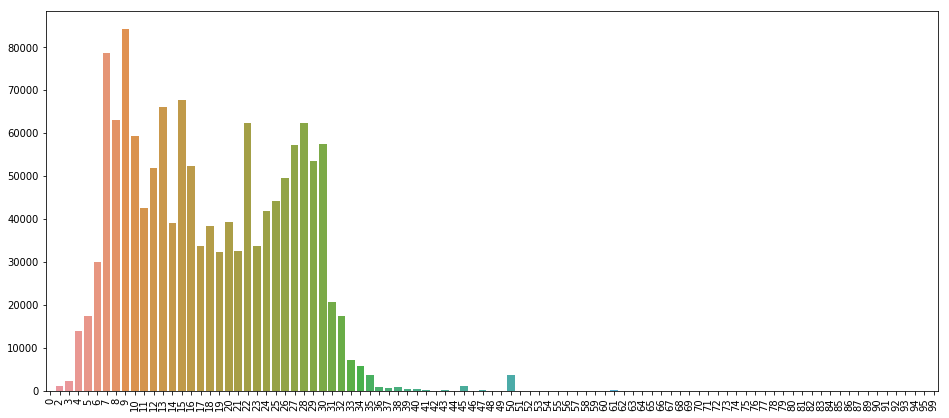

In [94]:

df = t5.sum()

plt.figure(figsize=(16,7))
sns.barplot(x=df.index,y=df.values)
plt.xticks(rotation=90)


In [95]:
#Renaming columns
t5.columns = ['t_titles_letters', '0','2','3','4','5','6','7','8','9','10',
                                 '11','12','13','14','15','16','17','18','19','20',
                                 '21','22','23','24','25','26','27','28','29','30','31','32',
                '33','34','35','36','37','38','39','40','41','42','43',
                '44','45','46','47','48','49','50','51','52','53','54',
                '55','56','57','58','59','60','61','62','63','64','65',
                '66','67','68','69','70','71','72','73','74','75','76',
                '77','78','79','80','81','82','83','84','85','86','87',
                '89','90','91','92','93','94','95','99']

In [96]:
t5.loc[:,['0','2','3','4','5','6','7','8','9','10']].sum(axis=1).sum(axis=0)

350803

In [97]:
t5.loc[:,['11','12','13','14','15','16','17','18','19','20']].sum(axis=1).sum(axis=0)

463813

In [98]:
t5.loc[:,['21','22','23','24','25','26','27','28','29','30']].sum(axis=1).sum(axis=0)

494799

In [99]:
t5.loc[:,['31','32',
                '33','34','35','36','37','38','39','40','41','42','43',
                '44','45','46','47','48','49','50','51','52','53','54',
                '55','56','57','58','59','60','61','62','63','64','65',
                '66','67','68','69','70','71','72','73','74','75','76',
                '77','78','79','80','81','82','83','84','85','86','87',
                '89','90','91','92','93','94','95','99']].sum(axis=1).sum(axis=0)

66080

In [100]:

# Merging columns less than 10 letters into one column
t5['letters_<10']= t5.loc[:,['0','2','3','4','5','6','7','8','9','10']].sum(axis=1)

# Merging columns 11-20 letters into one column
t5['letters_11-20']= t5.loc[:,['11','12','13','14','15','16','17','18','19','20']].sum(axis=1)

# Merging columns 21-30 letters into one column
t5['letters_21-30']= t5.loc[:,['21','22','23','24','25','26','27','28','29','30']].sum(axis=1)

# Merging columns greater than 31 letters into one column
t5['letters_31>']= t5.loc[:,['31','32',
                '33','34','35','36','37','38','39','40','41','42','43',
                '44','45','46','47','48','49','50','51','52','53','54',
                '55','56','57','58','59','60','61','62','63','64','65',
                '66','67','68','69','70','71','72','73','74','75','76',
                '77','78','79','80','81','82','83','84','85','86','87',
                '89','90','91','92','93','94','95','99']].sum(axis=1)

#making a copy
copy_t5 = t5.copy(deep=True)

#dropping the merged columns
t5.drop(labels=['0','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20',
                  '21','22','23','24','25','26','27','28','29','30','31','32',
                '33','34','35','36','37','38','39','40','41','42','43',
                '44','45','46','47','48','49','50','51','52','53','54',
                '55','56','57','58','59','60','61','62','63','64','65',
                '66','67','68','69','70','71','72','73','74','75','76',
                '77','78','79','80','81','82','83','84','85','86','87',
                '89','90','91','92','93','94','95','99'],axis=1,inplace=True)

# Assigning a value of 1
t5.loc[(t5['letters_<10'] > 0), 'letters_<10'] = 1
t5.loc[(t5['letters_11-20'] > 0), 'letters_11-20'] = 1
t5.loc[(t5['letters_21-30'] > 0), 'letters_21-30'] = 1
t5.loc[(t5['letters_31>'] > 0), 'letters_31>'] = 1

t5.head()

,t_titles_letters,letters_<10,letters_11-20,letters_21-30,letters_31>
0,"(7, 22, 26, 27, 28, 29)",1,0,1,0
1,"(35, 4, 3, 5, 7, 8, 9, 10, 13, 14, 15, 16, 17,...",1,1,1,1
2,"(8, 9, 13, 14, 20, 22, 26, 28, 30)",1,1,1,0
3,"(17, 6, 7)",1,1,0,0
4,(15),0,1,0,0


In [101]:
# Concatenating the letters dataframe with the main titles_train_df
titles_train_df = pd.concat([titles_train_df.reset_index(drop=True), t5], axis=1)

titles_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 28 columns):
ID                         200000 non-null object
segment                    200000 non-null int64
titles                     200000 non-null object
g5                         200000 non-null object
titles_time                200000 non-null object
titles_time_sum            200000 non-null int64
titles_time_mean           200000 non-null float64
titles_time_median         200000 non-null float64
titles_time_max            200000 non-null int64
titles_time_min            200000 non-null int64
titles_count               200000 non-null int64
Exclamation_count          200000 non-null int64
question_mark_count        200000 non-null int64
colon_count                200000 non-null int64
hyphen_count               200000 non-null int64
slash_count                200000 non-null int64
oblong_count               200000 non-null int64
other_punctuation_count    200000 non-null int64

In [102]:
# Words in the titles
titles_train_df['words_title_count']=titles_train_df['g5'].apply(lambda row: list(len(title.split()) for title in row))

In [103]:
# Making word related columns
t6 = pd.Series(titles_train_df['words_title_count']).apply(frozenset).to_frame(name='t_titles_words')

for t_titles_words in frozenset.union(*t6.t_titles_words):
    t6[t_titles_words] = t6.apply(lambda _: int(t_titles_words in _.t_titles_words), axis=1)

t6.head()

,t_titles_words,0,1,2,3,4,5,6,7,8,...,12,13,14,15,16,17,18,19,20,21
0,"(2, 5, 6, 7, 8)",0,0,1,0,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,"(1, 2, 3, 4, 5, 6, 8)",0,1,1,1,1,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
2,"(1, 2, 3, 5, 6)",0,1,1,1,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"(1, 5)",0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,(3),0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [104]:
t6.sum()

0         46
1     105951
2     113437
3     150196
4      98500
5     102616
6     102534
7      46907
8      46423
9       5069
10      1339
11      4001
12       243
13       137
14       181
15       193
16       167
17        54
18        32
19        26
20        10
21         4
dtype: int64

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21]), <a list of 22 Text xticklabel objects>)

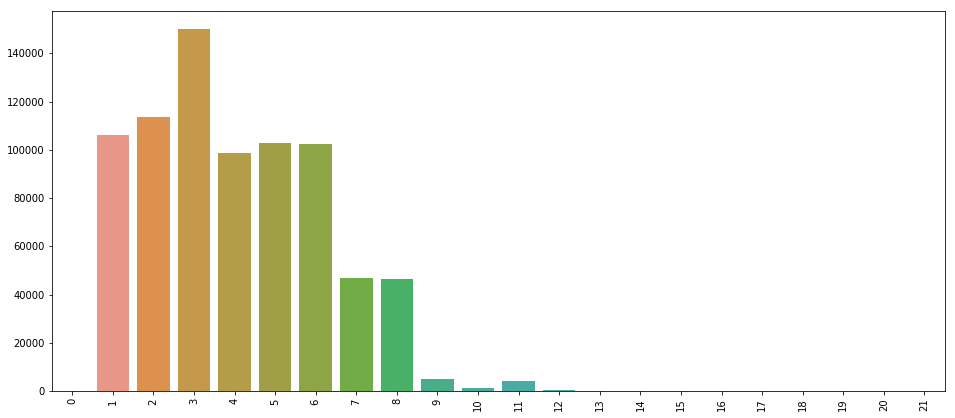

In [105]:
df1 = t6.sum()

plt.figure(figsize=(16,7))
sns.barplot(x=df1.index,y=df1.values)
plt.xticks(rotation=90)

In [108]:
# Merging columns greater than 6 words into one column
t6['6+']= t6.iloc[:,[8,9,10,11,12,13,14,15,16,17,18,19,20,21,22]].sum(axis=1)

#making a copy
copy_t6 = t6.copy(deep=True)

# renamimg columns
t6.columns = ['t_titles_words', '0','1','2','3','4','5','6','7','8',
                 '9','10','11','12','13','14','15','16','17','18','19','20','21','6+']

#dropping the merged columns
t6.drop(labels=['7','8','9','10','11','12','13','14','15','16','17','18','19','20','21'],axis=1,inplace=True)

# Assigning a value of 1
t6.loc[(t6['6+'] > 0), '6+'] = 1

t6.head()

,t_titles_words,0,1,2,3,4,5,6,6+
0,"(2, 5, 6, 7, 8)",0,0,1,0,0,1,1,1
1,"(1, 2, 3, 4, 5, 6, 8)",0,1,1,1,1,1,1,1
2,"(1, 2, 3, 5, 6)",0,1,1,1,0,1,1,0
3,"(1, 5)",0,1,0,0,0,1,0,0
4,(3),0,0,0,1,0,0,0,0


In [109]:
# Concatenating the words dataframe with the main titles_train_df
titles_train_df = pd.concat([titles_train_df.reset_index(drop=True), t6], axis=1)

titles_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 38 columns):
ID                         200000 non-null object
segment                    200000 non-null int64
titles                     200000 non-null object
g5                         200000 non-null object
titles_time                200000 non-null object
titles_time_sum            200000 non-null int64
titles_time_mean           200000 non-null float64
titles_time_median         200000 non-null float64
titles_time_max            200000 non-null int64
titles_time_min            200000 non-null int64
titles_count               200000 non-null int64
Exclamation_count          200000 non-null int64
question_mark_count        200000 non-null int64
colon_count                200000 non-null int64
hyphen_count               200000 non-null int64
slash_count                200000 non-null int64
oblong_count               200000 non-null int64
other_punctuation_count    200000 non-null int64

In [110]:
titles_train_df.to_csv('titles_train_features.csv')

In [234]:
# Finding the number of unique titles
s3 = set(titles_train_df['g5'].astype(str).str.replace('[',"").str.replace(']',"").str.replace('\'',"").str.replace('"',"").str.replace('`',"").str.cat(sep=',').split(','))
#len(s3)
df3 = pd.Series(list(s3))

df3.to_csv('unique-titles.csv')

In [240]:
titles_train_df['g5'].to_csv('titles.csv')

In [239]:
titles_train_df['g5'].apply(lambda comment: sum(str(comment).replace('\'','').replace('\"','').count(w) for w in '&+_')).sum()

91000

In [241]:
# Finding the length
titles_train_df['g5'].apply(lambda comment:(str(comment).replace('\'','').replace('\"','').replace('[','').replace(']',''))).head()

### Test Data

In [111]:
titles_test_df['g5'] = [re.sub(pattern='\:\d+',repl='',string=x) for x in titles_test_df['titles']]
titles_test_df['g5'] = titles_test_df['g5'].apply(lambda x: x.split(','))

In [112]:
# Aggregating titles on the basis of watch times of each dow
main = form_list(titles_test_df,'titles')
titles_test_df['titles_time'] = fill_blank(main)
aggregate(titles_test_df,'titles_time')
titles_test_df['titles_count'] = titles_test_df['titles'].map(wcount)

In [113]:
# Counting the number of punctuation marks

titles_test_df['Exclamation_count'] = titles_test_df['g5'].apply(lambda comment: str(comment).replace('\'','').replace('\"','').count('!'))
titles_test_df['question_mark_count'] = titles_test_df['g5'].apply(lambda comment: str(comment).replace('\'','').replace('\"','').count('?'))
titles_test_df['colon_count'] = titles_test_df['g5'].apply(lambda comment: str(comment).replace('\'','').replace('\"','').count(':'))
titles_test_df['hyphen_count'] =titles_test_df['g5'].apply(lambda comment: sum(str(comment).replace('\'','').replace('\"','').count(w) for w in '-'))
titles_test_df['slash_count'] = titles_test_df['g5'].apply(lambda comment: str(comment).replace('\'','').replace('\"','').count('/'))
titles_test_df['oblong_count'] = titles_test_df['g5'].apply(lambda comment: str(comment).replace('\'','').replace('\"','').count('|'))
titles_test_df['other_punctuation_count'] = titles_test_df['g5'].apply(lambda comment: sum(str(comment).replace('\'','').replace('\"','').count(w) for w in ';(){}'))

In [114]:
# Counting the number of symbols like &_+, num symbols like %*

titles_test_df['other_symbols_count'] = titles_test_df['g5'].apply(lambda comment: sum(str(comment).replace('\'','').replace('\"','').count(w) for w in '&+_'))
titles_test_df['num_symbols_count'] = titles_test_df['g5'].apply(lambda comment: sum(str(comment).replace('\'','').replace('\"','').count(w) for w in '*%'))

In [115]:
# Counting the number of numbers(0-9)

titles_test_df['num_count'] = titles_test_df['g5'].apply(lambda comment: sum(str(comment).replace('\'','').replace('\"','').count(w) for w in '0123456789'))

In [116]:
# Counting the number of capital letters
titles_test_df['capital_count'] = titles_test_df['g5'].apply(lambda comment: sum(1 for c in comment if p.match(c)))

In [117]:
# Letters in the titles
titles_test_df['titles_len']=titles_test_df['g5'].apply(lambda row: len_title(row))

In [118]:
# Creating columns
t5_te = pd.Series(titles_test_df['titles_len']).apply(frozenset).to_frame(name='t_titles_len')

for t_titles_len in frozenset.union(*t5_te.t_titles_len):
    t5_te[t_titles_len] = t5_te.apply(lambda _: int(t_titles_len in _.t_titles_len), axis=1)

t5_te.head()

,t_titles_len,0,2,3,4,5,6,7,8,9,...,87,88,89,90,91,92,93,94,95,99
0,"(32, 33, 9, 12, 14, 19, 20, 21, 22, 23, 24, 25...",0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,"(16, 19, 15)",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"(7, 12, 13, 24, 27, 28, 30)",0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"(8, 20)",0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,"(11, 13, 15, 22, 28, 29)",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
        85, 86, 87, 88, 89, 90, 91, 92, 93]),
 <a list of 94 Text xticklabel objects>)

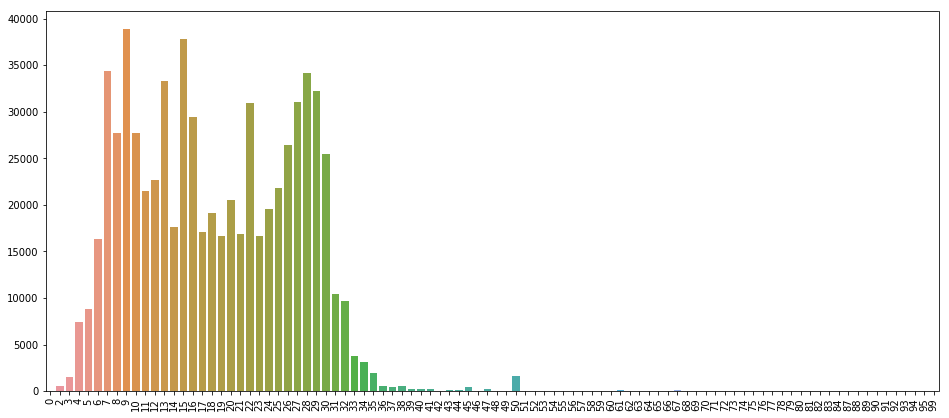

In [119]:
df = t5_te.sum()

plt.figure(figsize=(16,7))
sns.barplot(x=df.index,y=df.values)
plt.xticks(rotation=90)

In [120]:
#Renaming columns
t5_te.columns = ['t_titles_letters', '0','2','3','4','5','6','7','8','9','10',
                                 '11','12','13','14','15','16','17','18','19','20',
                                 '21','22','23','24','25','26','27','28','29','30','31','32',
                '33','34','35','36','37','38','39','40','41','42','43',
                '44','45','46','47','48','49','50','51','52','53','54',
                '55','56','57','58','59','60','61','62','63','64','65',
                '66','67','68','69','70','71','72','73','74','75','76',
                '77','78','79','80','81','82','83','84','86','87',
                '89','90','91','92','93','94','95','99']

In [122]:

# Merging columns less than 10 letters into one column
t5_te['letters_<10']= t5_te.loc[:,['0','2','3','4','5','6','7','8','9','10']].sum(axis=1)

# Merging columns 11-20 letters into one column
t5_te['letters_11-20']= t5_te.loc[:,['11','12','13','14','15','16','17','18','19','20']].sum(axis=1)

# Merging columns 21-30 letters into one column
t5_te['letters_21-30']= t5_te.loc[:,['21','22','23','24','25','26','27','28','29','30']].sum(axis=1)

# Merging columns greater than 31 letters into one column
t5_te['letters_31>']= t5_te.loc[:,['31','32',
                '33','34','35','36','37','38','39','40','41','42','43',
                '44','45','46','47','48','49','50','51','52','53','54',
                '55','56','57','58','59','60','61','62','63','64','65',
                '66','67','68','69','70','71','72','73','74','75','76',
                '77','78','79','80','81','82','83','84','86','87',
                '89','90','91','92','93','94','95','99']].sum(axis=1)

#making a copy
copy_t5_te = t5_te.copy(deep=True)

#dropping the merged columns
t5_te.drop(labels=['0','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20',
                  '21','22','23','24','25','26','27','28','29','30','31','32',
                '33','34','35','36','37','38','39','40','41','42','43',
                '44','45','46','47','48','49','50','51','52','53','54',
                '55','56','57','58','59','60','61','62','63','64','65',
                '66','67','68','69','70','71','72','73','74','75','76',
                '77','78','79','80','81','82','83','84','86','87',
                '89','90','91','92','93','94','95','99'],axis=1,inplace=True)

# Assigning a value of 1
t5_te.loc[(t5_te['letters_<10'] > 0), 'letters_<10'] = 1
t5_te.loc[(t5_te['letters_11-20'] > 0), 'letters_11-20'] = 1
t5_te.loc[(t5_te['letters_21-30'] > 0), 'letters_21-30'] = 1
t5_te.loc[(t5_te['letters_31>'] > 0), 'letters_31>'] = 1

t5_te.head()

,t_titles_letters,letters_<10,letters_11-20,letters_21-30,letters_31>
0,"(32, 33, 9, 12, 14, 19, 20, 21, 22, 23, 24, 25...",1,1,1,1
1,"(16, 19, 15)",0,1,0,0
2,"(7, 12, 13, 24, 27, 28, 30)",1,1,1,0
3,"(8, 20)",1,1,0,0
4,"(11, 13, 15, 22, 28, 29)",0,1,1,0


In [123]:
# Concatenating the letters dataframe with the main titles_train_df
titles_test_df = pd.concat([titles_test_df.reset_index(drop=True), t5_te], axis=1)

titles_test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 27 columns):
ID                         100000 non-null object
titles                     100000 non-null object
g5                         100000 non-null object
titles_time                100000 non-null object
titles_time_sum            100000 non-null int64
titles_time_mean           100000 non-null float64
titles_time_median         100000 non-null float64
titles_time_max            100000 non-null int64
titles_time_min            100000 non-null int64
titles_count               100000 non-null int64
Exclamation_count          100000 non-null int64
question_mark_count        100000 non-null int64
colon_count                100000 non-null int64
hyphen_count               100000 non-null int64
slash_count                100000 non-null int64
oblong_count               100000 non-null int64
other_punctuation_count    100000 non-null int64
other_symbols_count        100000 non-null int64


In [124]:
# Words in the titles
titles_test_df['words_title_count']=titles_test_df['g5'].apply(lambda row: list(len(title.split()) for title in row))

In [125]:
# Making word related columns
t6_te = pd.Series(titles_test_df['words_title_count']).apply(frozenset).to_frame(name='t_titles_words')

for t_titles_words in frozenset.union(*t6_te.t_titles_words):
    t6_te[t_titles_words] = t6_te.apply(lambda _: int(t_titles_words in _.t_titles_words), axis=1)

t6_te.head()

,t_titles_words,0,1,2,3,4,5,6,7,8,...,12,13,14,15,16,17,18,19,20,21
0,"(1, 3, 4, 5, 6, 7, 8)",0,1,0,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,"(3, 4)",0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"(3, 4, 6, 7)",0,0,0,1,1,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
3,"(1, 4)",0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"(2, 3, 5, 6, 8)",0,0,1,1,0,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0


In [126]:
t6_te.sum()

0        12
1     53491
2     55960
3     74344
4     46530
5     50746
6     51725
7     22215
8     29140
9      3211
10      486
11     1748
12      121
13       53
14      126
15      102
16       84
17       14
18       21
19       12
20        5
21        4
dtype: int64

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21]), <a list of 22 Text xticklabel objects>)

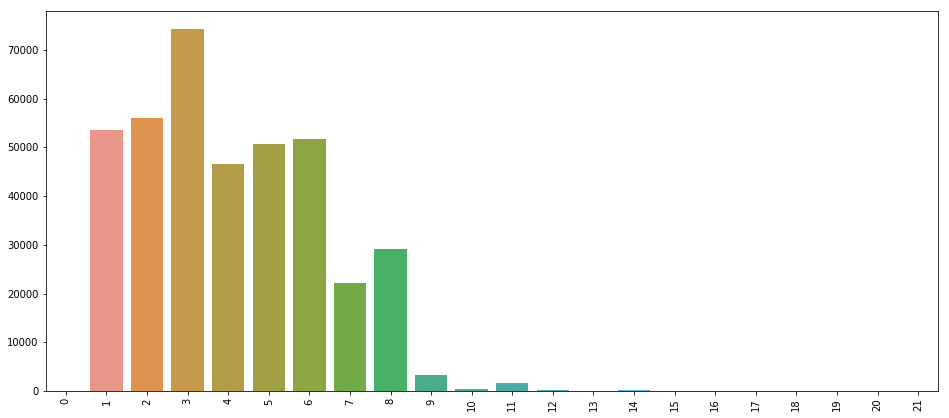

In [127]:
df1 = t6_te.sum()

plt.figure(figsize=(16,7))
sns.barplot(x=df1.index,y=df1.values)
plt.xticks(rotation=90)

In [129]:
# Merging columns greater than 6 words into one column
t6_te['6+']= t6_te.iloc[:,[8,9,10,11,12,13,14,15,16,17,18,19,20,21,22]].sum(axis=1)

#making a copy
copy_t6_te = t6_te.copy(deep=True)

# renamimg columns
t6_te.columns = ['t_titles_words', '0','1','2','3','4','5','6','7','8',
                 '9','10','11','12','13','14','15','16','17','18','19','20','21','6+']

#dropping the merged columns
t6_te.drop(labels=['7','8','9','10','11','12','13','14','15','16','17','18','19','20','21'],axis=1,inplace=True)

# Assigning a value of 1
t6_te.loc[(t6_te['6+'] > 0), '6+'] = 1

t6_te.head()

,t_titles_words,0,1,2,3,4,5,6,6+
0,"(1, 3, 4, 5, 6, 7, 8)",0,1,0,1,1,1,1,1
1,"(3, 4)",0,0,0,1,1,0,0,0
2,"(3, 4, 6, 7)",0,0,0,1,1,0,1,1
3,"(1, 4)",0,1,0,0,1,0,0,0
4,"(2, 3, 5, 6, 8)",0,0,1,1,0,1,1,1


In [130]:
# Concatenating the words dataframe with the main titles_train_df
titles_test_df = pd.concat([titles_test_df.reset_index(drop=True), t6_te], axis=1)

titles_test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 37 columns):
ID                         100000 non-null object
titles                     100000 non-null object
g5                         100000 non-null object
titles_time                100000 non-null object
titles_time_sum            100000 non-null int64
titles_time_mean           100000 non-null float64
titles_time_median         100000 non-null float64
titles_time_max            100000 non-null int64
titles_time_min            100000 non-null int64
titles_count               100000 non-null int64
Exclamation_count          100000 non-null int64
question_mark_count        100000 non-null int64
colon_count                100000 non-null int64
hyphen_count               100000 non-null int64
slash_count                100000 non-null int64
oblong_count               100000 non-null int64
other_punctuation_count    100000 non-null int64
other_symbols_count        100000 non-null int64


In [131]:
titles_test_df.head()

,ID,titles,g5,titles_time,titles_time_sum,titles_time_mean,titles_time_median,titles_time_max,titles_time_min,titles_count,...,words_title_count,t_titles_words,0,1,2,3,4,5,6,6+
0,test-23855,"Day 4: India Move in for the Kill:993,Man Unit...","[Day 4: India Move in for the Kill, Man United...","[993, 180, 6, 633, 34, 176, 506, 5, 899, 2784,...",26545,617.325581,180.0,32,993,43,...,"[8, 4, 3, 6, 4, 4, 6, 5, 5, 4, 4, 4, 6, 3, 6, ...","(1, 3, 4, 5, 6, 7, 8)",0,1,0,1,1,1,1,1
1,test-23854,"The Cannes Special:137,Koffee With Karan:2275,...","[The Cannes Special, Koffee With Karan, Shaadi...","[137, 2275, 1640]",4052,1350.666667,1640.0,1640,137,3,...,"[3, 3, 4]","(3, 4)",0,0,0,1,1,0,0,0
2,test-23857,"Andaz Apna Apna:343,RPS vs MI Hindi:566,Yuvraj...","[Andaz Apna Apna, RPS vs MI Hindi, Yuvraj Blaz...","[343, 566, 0, 997, 0, 8, 2569]",4483,640.428571,343.0,2569,343,7,...,"[3, 4, 7, 6, 3, 7, 6]","(3, 4, 6, 7)",0,0,0,1,1,0,1,1
3,test-23856,"Mounam Sammatham Part 3:930,Pranayam:91","[Mounam Sammatham Part 3, Pranayam]","[930, 91]",1021,510.500000,510.5,91,930,2,...,"[4, 1]","(1, 4)",0,1,0,0,1,0,0,0
4,test-23851,"Savdhaan India:233,India vs England | 2nd ODI ...","[Savdhaan India, India vs England | 2nd ODI | ...","[233, 214, 0, 3792, 5000, 139]",9378,1563.000000,223.5,139,233,6,...,"[2, 8, 3, 5, 3, 6]","(2, 3, 5, 6, 8)",0,0,1,1,0,1,1,1


In [132]:
titles_test_df.to_csv('titles_test_features.csv')